In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [161]:
from collections import defaultdict, Counter
from collections.abc import Iterable
from functools import partial
import gc
import inspect
import matplotlib.pyplot as plt
import numpy as np
from operator import gt, lt, add, sub
import os
import pandas as pd
from tabulate import tabulate
import shutil
from sklearn.metrics import (accuracy_score, dcg_score, roc_auc_score, 
                             precision_score, recall_score)
from textblob import TextBlob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
import warnings

from accio.s3tool import S3tool
from htools import (load, save, hdir, LoggerMixin, eprint, assert_raises,
                    auto_repr, valuecheck, debug, wrapmethods)
from ml_htools.torch_utils import (ModelMixin, variable_lr_optimizer,
                                   update_optimizer, DEVICE, stats, adam)
from spellotape.utils import stop_instance

In [3]:
# Reproducible testing.
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

# To Do:

- Build + add + test LRScheduler

In [4]:
class Data(Dataset):
    
    def __init__(self, n=64, dim=2):
        self.x = torch.rand(n, dim).float()
        self.y = torch.clamp(
            (self.x[:, 0]*.75 + self.x[:, 1]*.25).round(), 0, 1
        ).abs().unsqueeze(-1)
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)

In [5]:
class MulticlassData(Dataset):
    
    def __init__(self, n=64, dim=2):
        self.x = torch.rand(n, dim).float()
        # Integer labels between 0 and 4, inclusive.
        self.y = torch.clamp(
            torch.round(
                torch.randint(6, (n, 1)).float() 
                * (self.x[:, 0]*.75 + self.x[:, 1]*.25).unsqueeze(-1)
            ), 0, 4).long().flatten()
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)

In [92]:
ypred_ = torch.rand(5, 2)
y_ = torch.tensor([0, 1, 1, 0, 1])
ypred_, y_

(tensor([[0.6056, 0.7756],
         [0.9752, 0.1870],
         [0.7654, 0.6673],
         [0.7638, 0.7371],
         [0.3130, 0.1048]]), tensor([0, 1, 1, 0, 1]))

In [100]:
ypred_.softmax(-1).argmax(-1).dtype

torch.int64

In [128]:
F.cross_entropy(ypred_, y_)

tensor(0.8341)

In [105]:
ypred_.softmax(-1)

tensor([[0.4576, 0.5424],
        [0.6874, 0.3126],
        [0.5245, 0.4755],
        [0.5067, 0.4933],
        [0.5518, 0.4482]])

In [107]:
F.binary_cross_entropy(ypred_.softmax(-1)[:, -1], y_.float())

tensor(0.8341)

In [94]:
F.cross_entropy(ypred_, y_)

tensor(0.8341)

In [96]:
F.nll_loss(ypred_.log_softmax(-1), y_)

tensor(0.8341)

In [111]:
yhat_ml = torch.randn(5, 4)
y_ml = torch.tensor([[0, 1, 0, 0], [1, 1, 1, 1], [0, 0, 1, 1], [0, 0, 0, 0], [1, 0, 0, 0]])
yhat_ml, y_ml

(tensor([[ 0.7133,  0.3655, -0.8358, -1.9481],
         [ 0.2853,  0.4204,  1.1918, -0.1397],
         [-0.7091, -0.4798,  0.6764, -0.9395],
         [ 0.0455,  0.1627, -0.0585,  1.9224],
         [ 0.4511,  0.5359,  0.2715,  0.5810]]), tensor([[0, 1, 0, 0],
         [1, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 0],
         [1, 0, 0, 0]]))

In [132]:
(torch.sigmoid(yhat_ml) > 0.5).float()

tensor([[1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [0., 0., 1., 0.],
        [1., 1., 0., 1.],
        [1., 1., 1., 1.]])

In [126]:
F.binary_cross_entropy_with_logits(yhat_ml, y_ml.float(), reduction='none')

tensor([[1.1121, 0.5270, 0.3601, 0.1333],
        [0.5606, 0.5049, 0.2652, 0.7654],
        [0.4002, 0.4818, 0.4111, 1.2694],
        [0.7162, 0.7778, 0.6643, 2.0589],
        [0.4928, 0.9966, 0.8381, 1.0253]])

In [123]:
-y_ml.float() * torch.log(torch.sigmoid(yhat_ml))

tensor([[0.0000, 0.5270, 0.0000, 0.0000],
        [0.5606, 0.5049, 0.2652, 0.7654],
        [0.0000, 0.0000, 0.4111, 1.2694],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.4928, 0.0000, 0.0000, 0.0000]])

In [124]:
-(1 - y_ml.float()) * torch.log(1 - torch.sigmoid(yhat_ml))

tensor([[1.1121, 0.0000, 0.3601, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.4002, 0.4818, 0.0000, 0.0000],
        [0.7162, 0.7778, 0.6643, 2.0589],
        [0.0000, 0.9966, 0.8381, 1.0253]])

**Note: F.cross_entropy combines F.log_softmax and F.nll_loss. However, for last_act we still want F.softmax, as this will create interpretable probabilities.**

In [391]:
class Trainer(LoggerMixin):
    
    @valuecheck
    def __init__(self, net, ds_train, ds_val, dl_train, dl_val,
                 criterion, mode:('binary', 'multiclass', 'regression'),
                 out_dir, bucket=None, optim_type=Adam, eps=1e-3, 
                 last_act=None, threshold=0.5,
                 metrics=None, callbacks=None, device=DEVICE):
        """
        Classification Loss Function Reference (k = number of classes)

        Loss                               y shape  yhat shape  dtype
        --------------------------------------------------------------        
        binary_cross_entropy_with_logits   (bs, 1)  (bs, 1)     float
        "" (multilabel case)               (bs, k)  (bs, k)     float
        cross_entropy                      (bs,)    (bs, k)     long
        
        Parameters
        ----------
        mode: str
            Specifies the problem type. Multi-label classification is 
            considered 'binary' as well since each example receives a binary
            prediction for each class.
        last_act: callable or None
            Last activation function to be applied outside the model. 
            For example, for a binary classification problem, if we choose
            to use binary_cross_entropy_with_logits loss but want to compute
            some metric using soft predictions, we would pass in torch.sigmoid
            for last act. For a multi-class problem using F.cross_entropy loss,
            we would need to pass in F.softmax to compute predicted 
            probabilities.  Remember this is ONLY necessary if all of the 
            following conditions are met:
            1. It is a classification problem.
            2. We have excluded the final activation from our model for 
            numerical stability reasons. (I.E. the loss function has the 
            the final activation built into it.)
            3. We wish to compute 1 or more metrics based on soft predictions,
            such as AUC-ROC.
        optim: torch.optim callable
            Callable optimizer. The default is Adam.
        threshold: float or None
            For a classification problem, pass in the decision threshold to
            use when converting soft predictions to hard predictions. For a
            regression problem, pass in None.
        """
        self.net = net
        self.ds_train, self.ds_val = ds_train, ds_val
        self.dl_train, self.dl_val = dl_train, dl_val
        # Optim created in fit() method. Must be after net is on the GPU.
        self.optim_type = optim_type
        self.optim = None
        self.eps = eps
        self.criterion = criterion
        self.mode = mode
        self.device = DEVICE
        self.last_act = last_act
        self.thresh = threshold
        self._stop_training = False
        # For now, only print logs. During training, a file will be created.
        self.logger = self.get_logger()
    
        # Storage options.
        self.out_dir = out_dir
        self.bucket = bucket
        os.makedirs(out_dir, exist_ok=True)
        
        # Dict makes it easier to adjust callbacks after creating model.
        self.callbacks = {}
        self.add_callbacks(*[BasicConfig(), StatsHandler(), MetricPrinter()] 
                           + (callbacks or []))
        self.metrics = [batch_size] + (metrics or [])
    
    def save(self, fname):
        save(self, os.path.join(self.out_dir, fname))
        
    def load(self, fname):
        """This lets a trainer load a previously saved state. This is NOT
        an in-place operation: the new trainer is simply returned.
        
        Parameters
        ----------
        fname: str
            Name of file where Trainer object is stored. Must end in either
            .zip or .pkl. Do not include the full path. This automatically
            checks the output directory.
        
        Examples
        --------
        trainer = Trainer(...)
        trainer.fit(...)
        trainer.save('v1')
        trainer = trainer.load('v1')
        """
        return load(self, os.path.join(self.out_dir, fname))
    
    @staticmethod
    def from_file(path):
        """Ths lets us load a previously saved Trainer. Unlike load(), this
        does not require us to have a Trainer instance first. The intent is
        that load() works well when within a single Jupyter notebook session,
        but when returning to work on a different day, we may not have a live
        instance of Trainer and a staticmethod lets us load without
        remembering all the arguments used at initialization time.
        
        Parameters
        ----------
        path: str
            Full path to saved file. This differs from load() because here, we
            don't have an instance with an out_dir attribute to check.
        """
        return load(path)
    
    def add_callbacks(self, *callbacks):
        """
        Parameters
        ----------
        callbacks: TorchCallback
            One or more callbacks to append to 
        """
        self.callbacks.update({type(cb).__name__: cb for cb in callbacks})
        self.callbacks = dict(sorted(self.callbacks.items(),
                                     key=lambda x: x[1].priority))
    
    def add_metrics(self, *metrics):
        self.metrics.extend(metrics)
    
    def fit(self, epochs, lrs=3e-3, lr_mult=1.0, clean=False): 
        stats = defaultdict(list)
        sum_i = 0
        _ = self.decide_stop('on_train_begin', lrs, lr_mult, clean)
        for e in range(1, epochs+1):
            _ = self.decide_stop('on_epoch_begin', e, stats, None)
            for i, batch in enumerate(self.dl_train, 1):
                sum_i += 1
                *xb, yb = map(lambda x: x.to(self.device), batch)
                self.optim.zero_grad()
                _ = self.decide_stop('on_batch_begin', i, sum_i, stats)
                
                # Forward and backward passes.
                y_score = self.net(*xb)
                loss = self.criterion(y_score, yb)
                loss.backward()
                self.optim.step()
                
                # Separate because callbacks are only applied during training.
                self._update_stats(stats, loss, yb, y_score.detach())
                if self.decide_stop('on_batch_end', i, sum_i, stats): break
            
            # If on_batch_end callback halts training, else block is skipped.  
            else: 
                val_stats = self.validate()
                if self.decide_stop('on_epoch_end', e, stats, val_stats): break
                continue
            break  
        _ = self.decide_stop('on_train_end', e, stats, val_stats)
    
    def validate(self, dl_val=None):
        # Allow user to pass in different loader outside of training.
        dl_val = self.dl_val or dl_val
        val_stats = defaultdict(list)
        self.net.eval()
        with torch.no_grad():
            for batch in dl_val:
                *xb, yb = map(lambda x: x.to(self.device), batch)
                y_score = self.net(*xb)
                loss = self.criterion(y_score, yb)
                self._update_stats(val_stats, loss, yb, y_score)
        return val_stats
        
    def _update_stats(self, stats, loss, yb, y_score):
        """Update stats in place.
        
        Parameters
        ----------
        stats: defaultdict[str, list]
        loss: torch.Tensor
            Tensor containing single value (mini-batch loss).
        yb: torch.Tensor
            Mini-batch of labels.
        y_pred: torch.Tensor
            Mini-batch of predictions.
            
        Returns
        -------
        None
        """
        # Final activation often excluded from network architecture.
        try:
            y_score = self.last_act(y_score)
        except TypeError:
            pass
        
        # Convert soft predictions to hard predictions.
        if self.mode == 'binary':
            # In multi-label case, this will have shape (bs, k).
            y_pred = (y_score > self.thresh).float()
        elif self.mode == 'multiclass':
            y_pred = y_score.argmax(-1)
        elif self.mode == 'regression':
            y_pred = y_score
            
        stats['loss'].append(loss.detach().cpu().numpy().item())
        for m in self.metrics:
            yhat = y_pred if hasarg(m, 'y_pred') else y_score
            stats[m.__name__.replace('_score', '')].append(m(yb, yhat))
        
    def decide_stop(self, attr, *args, **kwargs):
        self._stop_training = False
        # Pass model object as first argument to callbacks.
        for cb in self.callbacks.values():
            getattr(cb, attr)(self, *args, **kwargs)
        return self._stop_training
    
    def unfreeze(self, n_layers=None, n_groups=None):
        """Pass in either the number of layers or number of groups to 
        unfreeze. Unfreezing always starts at the end of the network and moves
        backward (e.g. n_layers=1 will unfreeze the last 1 layer, or n_groups=2 
        will unfreeze the last 2 groups.) Remember than weights and biases are 
        treated as separate layers.
        """
        mode = 'layers' if n_layers is not None else 'groups'
        self.logger.info(f'Unfreezing last {n_layers or n_groups} {mode}.')
        self.net.unfreeze(n_layers, n_groups)
            
    def freeze(self):
        """Freeze whole network."""
        self.logger.info('Freezing whole network.')
        self.net.unfreeze(n_layers=0)
    
    def cleanup(self, confirmed):
        """Delete output directory. An empty directory with the same name
        will be created in its place.
        
        Parameters
        ----------
        confirm: bool
            Placeholder variable. This is just intended to force the user
            to confirm their desire to delete files before doing it. If
            True, the directory will be deleted. (Technically, any truthy
            value will work.)
            
        Returns
        -------
        None
        """
        if not confirmed: return
        self.logger.info('Removing files from output directory.')
        shutil.rmtree(self.out_dir)
        os.makedirs(self.out_dir)
        
    def __repr__(self):
        r = (f'Trainer(criterion={repr(self.criterion.__name__)}, '
             f'out_dir={repr(self.out_dir)}, bucket={repr(self.bucket)})'
             f'\n\nDatasets: {len(self.ds_train)} train rows, '
             f'{len(self.ds_val)} val rows'
             f'\n\nOptimizer: {repr(self.optim)}'
             f'\n\n{repr(self.net)})')
        return r

In [345]:
class BaseModel(nn.Module):
    
    def unfreeze(self, n_layers=None, n_groups=None):
        """Pass in either the number of layers or number of groups to 
        unfreeze. Unfreezing always starts at the end of the network and moves
        backward (e.g. n_layers=1 will unfreeze the last 1 layer, or n_groups=2 
        will unfreeze the last 2 groups.) Remember than weights and biases are 
        treated as separate layers.
        """
        if n_groups is not None: 
            self._unfreeze_by_group(n_groups)
            return

        length = len(self)
        for i, p in enumerate(self.parameters()):
            p.requires_grad = i >= length - n_layers
            
    def freeze(self):
        """Freeze whole network."""
        self.unfreeze(n_layers=0)
        
    def _unfreeze_by_group(self, n_groups):
        """Helper for unfreeze() method."""
        length = len(self.groups)
        for i, group in enumerate(self.groups):
            setting = i >= length - n_groups
            for p in group.parameters():
                p.requires_grad = setting
                
    def __len__(self):
        """Number of parameter matrices in model (basically number of layers, 
        except that biases are counted separately).
        """
        return sum(1 for p in self.parameters())
    
    def dims(self):
        """Get shape of each layer's weights."""
        return [tuple(p.shape) for p in self.parameters()]

    def trainable(self):
        """Check which layers are trainable."""
        return [(tuple(p.shape), p.requires_grad) for p in self.parameters()]

    def weight_stats(self):
        """Check mean and standard deviation of each layer's weights."""
        return [stats(p.data, 3) for p in self.parameters()]

    def plot_weights(self):
        """Plot histograms of each layer's weights."""
        n_layers = len(self.dims())
        fig, ax = plt.subplots(n_layers, figsize=(8, n_layers * 1.25))
        if not isinstance(ax, Iterable): ax = [ax]
        for i, p in enumerate(self.parameters()):
            ax[i].hist(p.data.flatten())
            ax[i].set_title(f'Shape: {tuple(p.shape)} Stats: {stats(p.data)}')
        plt.tight_layout()
        plt.show()

In [346]:
class SimpleModel(BaseModel):
    
    def __init__(self, dim):
        super().__init__()  
        self.fc1 = nn.Linear(dim, 2)
        self.fc2 = nn.Linear(2, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)

In [347]:
class GroupedModel(BaseModel):
    
    def __init__(self, dim):
        super().__init__()  
        g1 = nn.Sequential(
            nn.Linear(dim, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 4),
            nn.LeakyReLU()
        )
        g2 = nn.Linear(4, 1)
        self.groups = nn.ModuleList([g1, g2])
        
    def forward(self, x):
        for group in self.groups:
            x = group(x)
        return x

In [348]:
DIM = 2

In [349]:
snet = SimpleModel(DIM)
snet

SimpleModel(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)

In [350]:
optim = variable_lr_optimizer(snet, 2e-3)
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.002
    weight_decay: 0
)

In [351]:
with assert_raises(ValueError) as ar:
    optim = variable_lr_optimizer(snet, [3e-3, 1e-1])
    optim

As expected, got ValueError(Received more learning rates than layer groups.).


In [352]:
update_optimizer(optim, 1e-3, 0.5)
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0
)

In [353]:
snet.freeze()
for n in range(5):
    snet.unfreeze(n_layers=n)
    print(n, snet.trainable())

0 [((2, 2), False), ((2,), False), ((1, 2), False), ((1,), False)]
1 [((2, 2), False), ((2,), False), ((1, 2), False), ((1,), True)]
2 [((2, 2), False), ((2,), False), ((1, 2), True), ((1,), True)]
3 [((2, 2), False), ((2,), True), ((1, 2), True), ((1,), True)]
4 [((2, 2), True), ((2,), True), ((1, 2), True), ((1,), True)]


In [354]:
snet.freeze()
with assert_raises(AttributeError) as ar:
    for n in range(3):
        snet.unfreeze(n_groups=n)
        print(n, snet.trainable())

As expected, got AttributeError('SimpleModel' object has no attribute 'groups').


In [355]:
gnet = GroupedModel(DIM)
gnet

GroupedModel(
  (groups): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [356]:
optim = variable_lr_optimizer(gnet, [1e-3, 3e-3])
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)

In [357]:
update_optimizer(optim, 2e-3, lr_mult=1/3)
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.0006666666666666666
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.002
    weight_decay: 0
)

In [358]:
variable_lr_optimizer(gnet, 1e-3)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0
)

In [359]:
variable_lr_optimizer(gnet, 1e-3, lr_mult=0.5)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.0005
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0
)

In [360]:
gnet.freeze()
for n in range(3):
    gnet.unfreeze(n_groups=n)
    print(n, gnet.trainable())

0 [((8, 2), False), ((8,), False), ((4, 8), False), ((4,), False), ((1, 4), False), ((1,), False)]
1 [((8, 2), False), ((8,), False), ((4, 8), False), ((4,), False), ((1, 4), True), ((1,), True)]
2 [((8, 2), True), ((8,), True), ((4, 8), True), ((4,), True), ((1, 4), True), ((1,), True)]


In [361]:
gnet.freeze()
for n in range(7):
    gnet.unfreeze(n_layers=n)
    print(n, gnet.trainable())

0 [((8, 2), False), ((8,), False), ((4, 8), False), ((4,), False), ((1, 4), False), ((1,), False)]
1 [((8, 2), False), ((8,), False), ((4, 8), False), ((4,), False), ((1, 4), False), ((1,), True)]
2 [((8, 2), False), ((8,), False), ((4, 8), False), ((4,), False), ((1, 4), True), ((1,), True)]
3 [((8, 2), False), ((8,), False), ((4, 8), False), ((4,), True), ((1, 4), True), ((1,), True)]
4 [((8, 2), False), ((8,), False), ((4, 8), True), ((4,), True), ((1, 4), True), ((1,), True)]
5 [((8, 2), False), ((8,), True), ((4, 8), True), ((4,), True), ((1, 4), True), ((1,), True)]
6 [((8, 2), True), ((8,), True), ((4, 8), True), ((4,), True), ((1, 4), True), ((1,), True)]


# Callbacks

In [362]:
@auto_repr
class TorchCallback:
    
    def on_train_begin(self, trainer, lrs, lr_mult, clean):
        pass
    
    def on_train_end(self, trainer, epoch, stats, val_stats):
        pass
    
    def on_epoch_begin(self, trainer, epoch, stats, val_stats):
        pass

    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        pass
    
    def on_batch_begin(self, trainer, i, sum_i, stats):
        pass
    
    def on_batch_end(self, trainer, i, sum_i, stats):
        pass

In [392]:
class BasicConfig(TorchCallback):
    """Handles basic model tasks like putting the model on the GPU
    and switching between train and eval modes.
    """
    
    def __init__(self, priority=0):
        self.priority = priority
    
    def on_train_begin(self, trainer, lrs, lr_mult, clean):
        trainer.net.to(DEVICE)
        trainer.optim = variable_lr_optimizer(
            trainer.net, lrs, lr_mult, trainer.optim_type, trainer.eps
        )
        if clean: trainer.cleanup(clean)

    def on_epoch_begin(self, trainer, *args, **kwargs):
        trainer.net.train()
        
    def on_train_end(self, trainer, *args, **kwargs):
        trainer.logger.info('Training complete. Model in eval mode.')
        trainer.net.eval()

In [393]:
class StatsHandler(TorchCallback):
    """This updates metrics at the end of each epoch to account for
    potentially varying batch sizes.
    """
    
    def __init__(self, priority=5):
        self.priority = priority
        
    def on_epoch_begin(self, trainer, epoch, stats, val_stats):
        """Resets stats at the start of each epoch."""
        stats.clear()
        
    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        """Computes (possibly weighted) averages of mini-batch stats
        at the end of each epoch.
        """
        for group in (stats, val_stats):
            for k, v in group.items():
                if k == 'batch_size': continue
                group[k] = np.average(v, weights=group['batch_size'])
            group.pop('batch_size')

In [394]:
class MetricPrinter(TorchCallback):
    """Prints metrics at the end of each epoch. This is one of the 
    default callbacks provided in BaseModel - it does not need to
    be passed in explicitly.
    """
    
    def __init__(self, priority=10):
        self.priority = priority
        
    def on_train_begin(self, trainer, *args, **kwargs):
        trainer.logger = trainer.get_logger(
            os.path.join(trainer.out_dir, 'train.log'),
            fmt='\n%(asctime)s\n %(message)s'
        )
    
    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        data = [[k, v, val_stats[k]] for k, v in stats.items()]
        table = tabulate(data, headers=['Metric', 'Train', 'Validation'], 
                         tablefmt='github', floatfmt='.4f')
        trainer.logger.info(f'\n{"="*5}\n\nEpoch {epoch}\n\n{table}\n')

In [395]:
class EarlyStopper(TorchCallback):
    
    @valuecheck
    def __init__(self, goal:('max', 'min'), metric='loss', min_improvement=0.0, 
                 patience=3, priority=15):
        """
        Parameters
        ----------
        goal: str
            Indicates what we want to do to the metric in question.
            Either 'min' or 'max'. E.g. metric 'loss' should have goal 'min'
            while metric 'precision' should have goal 'max'.
        metric: str
            Quantity to monitor. This will always be computed on the 
            validation set.
        min_improvement: float
            Amount of change needed to qualify as improvement. For example,
            min_improvement of 0.0 means any improvement is sufficient. With
            a min_improvent of 0.2, we will stop training even if the
            quantity improves by, for example, 0.1.
        patience: int
            Number of acceptable epochs without improvement. E.g. patience=0 
            means the metric must improve every epoch for training to continue.            
        """
        # Will use op like: self.op(new_val, current_best)
        if goal == 'min':
            self.init_metric = self.best_metric = float('inf')
            self.op = lt
            self.op_best = sub
        elif goal == 'max':
            self.init_metric = self.best_metric = float('-inf')
            self.op = gt
            self.op_best = add
           
        self.priority = priority
        self.metric = metric
        self.min_improvement = min_improvement
        self.patience = patience
        self.since_improvement = 0
        
    def on_train_begin(self, trainer, *args, **kwargs):
        """Resets tracked variables at start of training."""
        self.best_metric = self.init_metric
        self.since_improvement = 0
    
    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        # Error handling.
        new_val = val_stats.get(self.metric)
        if new_val is None:
            trainer.logger.info(f'EarlyStopper could not find {self.metric}. '
                                f'Callback behavior may not be enforced.')
            return
        
        # Expected behavior.
        if self.op(new_val, self.op_best(self.best_metric, self.min_improvement)):
            self.best_metric = new_val
            self.since_improvement = 0
        else:
            self.since_improvement += 1
            if self.since_improvement > self.patience:
                trainer.logger.info(
                    f'EarlyStopper halting training: validation {self.metric} '
                    f'has not improved enough in {self.since_improvement} epochs.'
                )
                trainer._stop_training = True

In [396]:
class PerformanceThreshold(TorchCallback):
    
    @valuecheck
    def __init__(self, metric, goal:('min', 'max'), threshold, skip_epochs=0, 
                 split:('train', 'val')='val', priority=15):
        self.priority = priority
        self.metric = metric
        self.threshold = threshold
        self.skip_epochs = skip_epochs
        self.split = split
        self.op = gt if goal == 'min' else lt
        
    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        if epoch <= self.skip_epochs:
            return
        
        # Error handling.
        data = val_stats if self.split == 'val' else stats
        new_val = data.get(self.metric)
        if new_val is None:
            trainer.logger.info(f'{self.metric} not found in metrics.'
                                 'PerformanceThreshold may not be enforced.')
            return
        
        # Expected behavior.
        if self.op(new_val, self.threshold):
            trainer.logger.info(
                f'PerformanceThreshold halting training: {self.metric} '
                f'of {new_val:.4f} did not meet threshold.'
            )
            trainer._stop_training = True

In [417]:
class ModelCheckpoint(TorchCallback):
    
    @valuecheck
    def __init__(self, metric='loss', goal:('max', 'min')='min', priority=25):
        # Will use op like: self.op(new_val, current_best)
        if goal == 'min':
            self.init_metric = self.best_metric = float('inf')
            self.op = lt
            self.op_best = sub
        elif goal == 'max':
            self.init_metric = self.best_metric = float('-inf')
            self.op = gt
            self.op_best = add

        self.priority = priority
        self.metric = metric
        self.model_dir = None
        
    def on_train_begin(self, trainer, *args, **kwargs):
        self.best_metric = self.init_metric
        
    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        new_val = val_stats.get(self.metric)
        # Error handling.
        if new_val is None:
            trainer.logger.info(f'{self.metric} not found in metrics.'
                                 'ModelCheckpoint may not save models.')
            return
            
        # Expected behavior.
        if self.op(new_val, self.best_metric):
            trainer.logger.info(
                f'Saving model. {self.metric.title()} improved from '
                f'{self.best_metric:.4f} to {new_val:.4f}.'
            )
            trainer.save(f'trainer.pkl')
            self.best_metric = new_val

In [398]:
class MetricHistory(TorchCallback):
    """Separate from StatsHandler in case we don't want to log outputs."""
    
    def __init__(self, fname='history.csv', plot_fname='history.png',
                 priority=90):
        self.train_hist = []
        self.val_hist = []
        self.fname = fname
        self.plot_fname = plot_fname
        self.priority = priority
        
    def on_train_begin(self, trainer, *args, **kwargs):
        self.train_hist.clear()
        self.val_hist.clear()
        
    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        self.train_hist.append(stats.copy())
        self.val_hist.append(val_stats.copy())
        
    def on_train_end(self, trainer, *args, **kwargs):
        self.df = pd.concat([
            pd.DataFrame(self.train_hist),
            pd.DataFrame(self.val_hist)\
              .rename(lambda x: f'val_{x}', axis='columns')
        ], axis=1)
        self.df.to_csv(os.path.join(trainer.out_dir, self.fname), 
                       index=False)
        self.plot(os.path.join(trainer.out_dir, self.plot_fname))
        
    def plot(self, path=None):
        cols = df.shape[1]
        fig, ax = plt.subplots(cols//4, 2, figsize=(12, cols))
        for i, axi in zip(range(cols // 2), ax.flatten()):
            col = df.columns[i]
            axi.plot(df[col], label='train')
            axi.plot(df[f'val_{col}'], label='val')
            axi.set_title(col.title())
            axi.set_xlabel('Epoch')
            axi.set_ylabel('Score')
            axi.legend()
        plt.tight_layout()
        if path: plt.savefig(path)
        plt.show()

In [399]:
class S3Uploader(TorchCallback):
    """Upload model and logs to S3 when training finishes."""
    
    def __init__(self, prefix, priority=95):
        self.prefix = prefix
        self.priority = priority
    
    def on_train_end(self, trainer, *args, **kwargs):
        paths = [f.path for f in os.scandir(trainer.out_dir)
                 if f.is_file() and not f.name.startswith('.')]
        s3 = S3tool()
        try:
            s3.upload_files(paths, trainer.bucket, self.prefix)
        except Exception as e:
            trainer.logger.error(e)

In [400]:
class EC2Closer(TorchCallback):
    
    def __init__(self, priority=100):
        self.priority = priority
        
    def on_train_end(self, trainer, *args, **kwargs):
        stop_instance()

In [401]:
class ModelUnfreezer(TorchCallback):
    """Gradually unfreeze a model during training.
    """
    
    @valuecheck
    def __init__(self, i2n, unfreeze_type:('groups', 'layers')='groups', 
                 mode:('batch', 'epoch')='epoch', priority=25):
        """
        Parameters
        ----------
        i2n: dict
            Maps index of batch/epoch to the number of layers or groups 
            to unfreeze at that point in time. 
        unfreeze_type: str
            Specifies whether to unfreeze groups or layers.
        mode: str
            Specifies whether the indices in `i2n` refer to batches or
            epochs.
        priority: int
            Determine place in the callback queue. Smaller numbers are
            executed earlier.
            
        Examples
        --------
        This will create a callback that unfreezes the last 2 layer
        groups at epoch 2, the last 3 groups at epoch 10, and the
        last 4 groups at epoch 25.
        
        ModelUnfreezer(
            i2n={2: 2, 10: 3, 25: 4},
            unfreeze_type='groups',
            mode='epoch'
        )
        """        
        self.priority = priority
        self.i2kwargs = {i: {f'n_{unfreeze_type}': n} 
                         for i, n in i2n.items()}
        self.mode = mode
        
    def on_batch_begin(self, trainer, i, sum_i, stats):
        if self.mode != 'batch': return
        
        kwargs = self.i2kwargs.get(i, None)
        if kwargs: trainer.unfreeze(**kwargs)
    
    def on_epoch_begin(self, trainer, epoch, stats, val_stats):
        if self.mode != 'epoch': return
        
        kwargs = self.i2kwargs.get(epoch, None)
        if kwargs: trainer.unfreeze(**kwargs)

In [402]:
class LRScheduler(TorchCallback):
    
    @valuecheck
    def __init__(self, func, mode:('batch', 'epoch'), lr_mult=1.0, 
                 priority=10):
        """
        func: function
            Accepts single parameter (either the current iteration number
            or the current epoch number) and returns a learnng rate.
        """
        self.func = func
        self.mode = mode
        self.lr_mult = lr_mult
        self.priority = priority
        
    def on_batch_begin(self, trainer, i, sum_i, stats):
        if self.mode != 'batch': return
        
        lr = self.func(sum_i)
        update_optimizer(trainer.optim, lr, lr_mult=self.lr_mult)
        trainer.logger.info(f'Set learning rate to {lr}.')
        
    def on_epoch_begin(self, trainer, epoch, stats, val_stats):
        if self.mode != 'epoch': return
        
        lr = self.func(epoch)
        update_optimizer(trainer.optim, lr, lr_mult=self.lr_mult)
        trainer.logger.info(f'Set learning rate to {lr}.')

In [403]:
mu = ModelUnfreezer({10:1, 20:2, 30:3}, 'groups')
print(mu.i2kwargs)

mu = ModelUnfreezer({100: 5, 200: 10, 350:13}, 'layers', 'batch')
print(mu.i2kwargs)

{10: {'n_groups': 1}, 20: {'n_groups': 2}, 30: {'n_groups': 3}}
{100: {'n_layers': 5}, 200: {'n_layers': 10}, 350: {'n_layers': 13}}


In [404]:
def back_translate(text, to, from_lang='en'):
    return TextBlob(text)\
        .translate(to=to)\
        .translate(from_lang=to, to=from_lang)

In [405]:
text = """
Visit ESPN to get up-to-the-minute sports news coverage, scores, highlights 
and commentary for NFL, MLB, NBA, College Football, NCAA Basketball and more.
"""
# back_translate(text, 'es')

# Metrics

Keep sklearn pattern with y_true as first argument.

For classification problems, round probabilities once instead of in every metric.

In [406]:
def hasarg(func, arg):
    """Checks if a function has a given argument. 
    Works with *args and **kwargs as well.
    
    Parameters
    ----------
    func: function
    arg: str
        Name of argument to look for.
    
    Returns
    -------
    bool
    """
    return arg in inspect.signature(func).parameters

In [407]:
def percent_positive(y_true, y_pred):
    """Compute the percent of predictions that are positive. This
    can help us identify when a model is predicting all ones or zeros.
    """
    return (y_pred == 1).float().mean()

In [408]:
def mean_soft_prediction(y_true, y_score):
    """Compute the mean predicted probability."""
    return y_score.mean() 

In [409]:
def batch_size(y_true, y_pred):
    """Count the number of items in the current batch."""
    return y_true.shape[0]

In [410]:
[hasarg(roc_auc_score, val) for val in ('y_score', 'y_pred')]

[True, False]

In [411]:
[hasarg(precision_score, val) for val in ('y_score', 'y_pred')]

[False, True]

# Training

In [412]:
DIM = 2
metrics = [accuracy_score, 
           precision_score, 
           recall_score, 
           percent_positive,
           mean_soft_prediction
          ]
# Model starts out unfrozen and freezes last group startingn with epoch 3.
# This is not useful but is done here for testing purposes.
callbacks = [EarlyStopper('max', 'accuracy', patience=3),
             PerformanceThreshold('recall', 'max', 0.25, skip_epochs=5),
             MetricHistory(),
             ModelUnfreezer({3:1}, 'groups'),
             ModelCheckpoint(),
             MetricHistory()
#              S3Uploader('mytorch_test')
            ]

In [413]:
train = Data(n=34, dim=DIM)
val = Data(n=30, dim=DIM)

dl_train = DataLoader(train, batch_size=8, shuffle=True)
dl_val = DataLoader(val, batch_size=8, shuffle=False)

In [414]:
gnet = GroupedModel(DIM)
t = Trainer(gnet, train, val, dl_train, dl_val, F.binary_cross_entropy_with_logits, 
            'binary', '../data/v1', 'datascience-delphi-dev', torch.optim.RMSprop, 
            last_act=torch.sigmoid, metrics=metrics, callbacks=callbacks)
t

Trainer(criterion='binary_cross_entropy_with_logits', out_dir='../data/v1', bucket='datascience-delphi-dev')

Datasets: 34 train rows, 30 val rows

Optimizer: None

GroupedModel(
  (groups): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
))

2020-02-13 15:44:28,421 [INFO]: Removing files from output directory.

2020-02-13 15:44:28,455
 
=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.0635 |       7.1353 |
| accuracy             |  0.4706 |       0.5000 |
| precision            |  0.4118 |       0.5000 |
| recall               |  0.7059 |       1.0000 |
| percent_positive     |  0.7059 |       1.0000 |
| mean_soft_prediction |  0.5524 |       1.0000 |


2020-02-13 15:44:28,455
 Saving model. Loss improved from inf to 7.1353.
Data written to ../data/v1/model.pkl.

2020-02-13 15:44:28,487
 
=====

Epoch 2

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.5633 |       0.9408 |
| accuracy             |  0.5882 |       0.5000 |
| precision            |  0.5000 |       0.5000 |
| recall               |  0.7647 |       1.0000 |
| percent_positive     |  0.764

/Users/harrisonmamin/.pyenv/versions/3.7.4/envs/main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


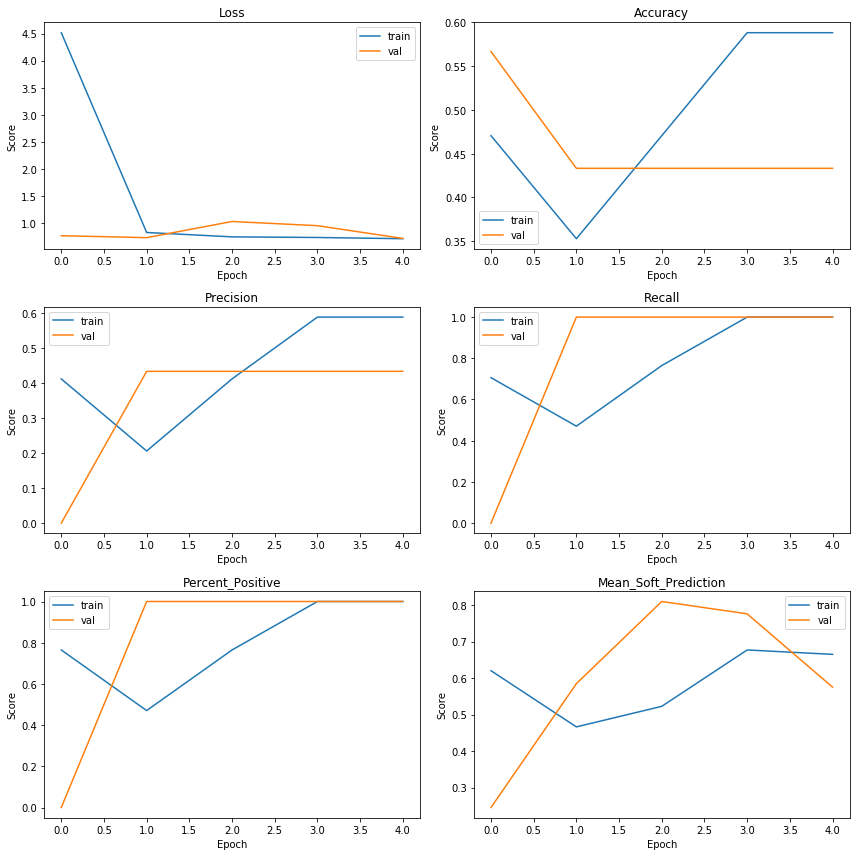

In [415]:
t.fit(10, 3e-1, 0.5, True)

In [416]:
!ls {t.out_dir}

history.csv history.png model.pkl   train.log


In [389]:
t.cleanup()

In [302]:
df = t.callbacks['MetricHistory'].df
df

,loss,accuracy,precision,recall,percent_positive,mean_soft_prediction,val_loss,val_accuracy,val_precision,val_recall,val_percent_positive,val_mean_soft_prediction
0,4.516430,0.470588,0.411765,0.705882,0.764706,0.620304,0.767629,0.566667,0.000000,0.0,0.0,0.245575
1,0.826754,0.352941,0.205882,0.470588,0.470588,0.466391,0.731025,0.433333,0.433333,1.0,1.0,0.584862
2,0.746070,0.470588,0.411765,0.764706,0.764706,0.522669,1.030030,0.433333,0.433333,1.0,1.0,0.809819
3,0.734676,0.588235,0.588235,1.000000,1.000000,0.677055,0.952614,0.433333,0.433333,1.0,1.0,0.776042
4,0.712079,0.588235,0.588235,1.000000,1.000000,0.665019,0.716807,0.433333,0.433333,1.0,1.0,0.575304


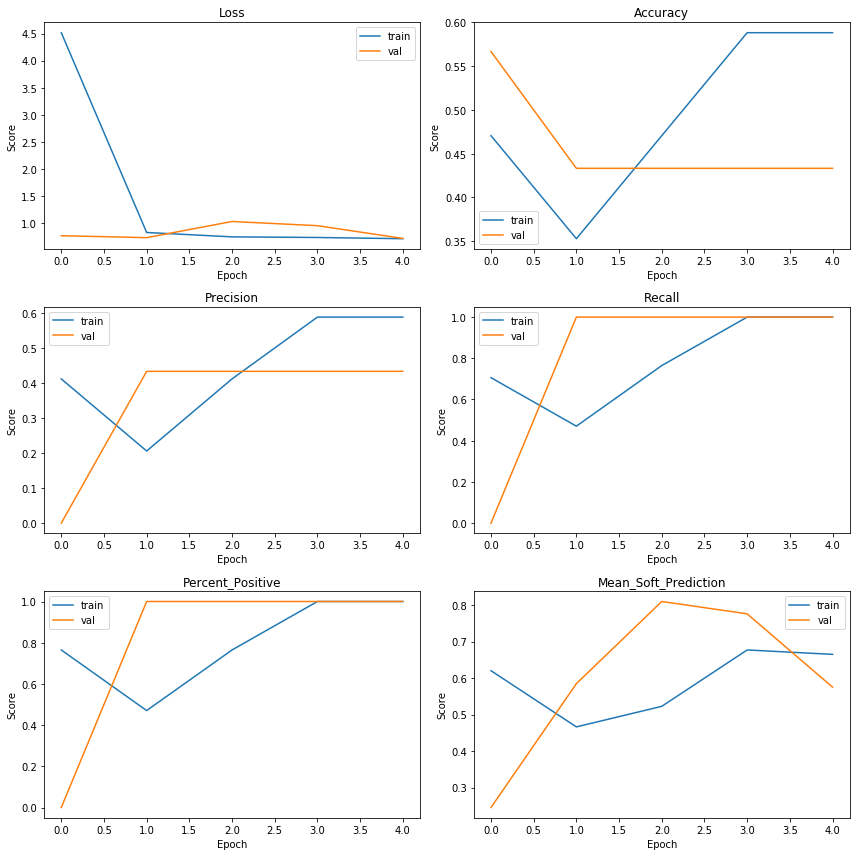

In [335]:
cols = df.shape[1]
fig, ax = plt.subplots(cols//4, 2, figsize=(12, cols))
for i, axi in zip(range(cols // 2), ax.flatten()):
    col = df.columns[i]
    axi.plot(df[col], label='train')
    axi.plot(df[f'val_{col}'], label='val')
    axi.set_title(col.title())
    axi.set_xlabel('Epoch')
    axi.set_ylabel('Score')
    axi.legend()
plt.tight_layout()
plt.show()

In [57]:
t.save('trainer.zip')

Data written to ../data/v1/trainer.zip.


In [58]:
t2 = Trainer.from_file(os.path.join('..', 'data', 'v1', 'trainer.zip'))
print(t2)
del t2; gc.collect()

Object loaded from ../data/v1/trainer.zip.
Trainer(criterion='binary_cross_entropy_with_logits', out_dir='../data/v1', bucket='datascience-delphi-dev')

Datasets: 34 train rows, 30 val rows

Optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.15
    momentum: 0
    weight_decay: 0

Parameter Group 1
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.3
    momentum: 0
    weight_decay: 0
)

GroupedModel(
  (groups): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
))


60

## Multiclass classification

In [68]:
class SimpleMulticlassModel(BaseModel):
    
    def __init__(self, dim, classes):
        super().__init__()  
        self.fc1 = nn.Linear(dim, 10)
        self.fc2 = nn.Linear(10, classes)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)

In [69]:
DIM = 2
metrics = [
           accuracy_score,
           mean_soft_prediction
          ]
callbacks = [EarlyStopper('max', 'accuracy', patience=3),
             PerformanceThreshold('recall', 'max', 0.25, skip_epochs=5),
             CSVLogger()
            ]

In [70]:
train = MulticlassData(n=34, dim=DIM)
val = MulticlassData(n=30, dim=DIM)

dl_train = DataLoader(train, batch_size=8, shuffle=True)
dl_val = DataLoader(val, batch_size=8, shuffle=False)

In [71]:
smnet = SimpleMulticlassModel(DIM, 5)
smnet

SimpleMulticlassModel(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
)

In [72]:
*x, y = next(iter(dl_train))
x, y

([tensor([[0.1534, 0.4195],
          [0.3988, 0.5501],
          [0.8462, 0.2889],
          [0.2998, 0.3309],
          [0.4153, 0.4969],
          [0.2942, 0.1801],
          [0.9153, 0.4671],
          [0.1523, 0.5825]])], tensor([0, 1, 1, 1, 1, 1, 3, 1]))

In [73]:
yhat = smnet(*x)
yhat

tensor([[-0.0107, -0.3381,  0.3051,  0.1568,  0.2844],
        [ 0.0150, -0.3844,  0.3131,  0.1717,  0.2668],
        [ 0.0367, -0.4394,  0.3508,  0.2325,  0.2392],
        [ 0.0012, -0.3585,  0.3092,  0.1602,  0.2823],
        [ 0.0152, -0.3851,  0.3132,  0.1723,  0.2658],
        [-0.0031, -0.3516,  0.3080,  0.1588,  0.2831],
        [ 0.0477, -0.4595,  0.3514,  0.2399,  0.2243],
        [-0.0067, -0.3444,  0.3062,  0.1580,  0.2837]],
       grad_fn=<AddmmBackward>)

In [74]:
y.shape, yhat.shape

(torch.Size([8]), torch.Size([8, 5]))

In [75]:
F.softmax(yhat, dim=-1)

tensor([[0.1780, 0.1283, 0.2441, 0.2105, 0.2391],
        [0.1827, 0.1225, 0.2461, 0.2137, 0.2350],
        [0.1841, 0.1144, 0.2521, 0.2240, 0.2255],
        [0.1800, 0.1256, 0.2449, 0.2110, 0.2384],
        [0.1827, 0.1225, 0.2462, 0.2138, 0.2348],
        [0.1793, 0.1265, 0.2447, 0.2108, 0.2387],
        [0.1865, 0.1123, 0.2527, 0.2260, 0.2225],
        [0.1787, 0.1275, 0.2443, 0.2107, 0.2389]], grad_fn=<SoftmaxBackward>)

In [76]:
yhat.shape, y.shape

(torch.Size([8, 5]), torch.Size([8]))

In [77]:
F.cross_entropy(yhat, y)

tensor(1.9728, grad_fn=<NllLossBackward>)

In [78]:
t = Trainer(smnet, train, val, dl_train, dl_val, F.cross_entropy, 'multiclass',
        '../data/v1', 'datascience-delphi-dev', last_act=partial(F.softmax, dim=-1),
            metrics=metrics, callbacks=callbacks)
t

Trainer(criterion='cross_entropy', out_dir='../data/v1', bucket='datascience-delphi-dev')

Datasets: 34 train rows, 30 val rows

Optimizer: None

SimpleMulticlassModel(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
))

In [79]:
t.fit(10, 1)


2020-02-13 13:25:55,451
 
=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  2.0907 |       1.1707 |
| accuracy             |  0.2059 |       0.5000 |
| mean_soft_prediction |  0.2000 |       0.2000 |


2020-02-13 13:25:55,461
 
=====

Epoch 2

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.6198 |       1.4233 |
| accuracy             |  0.2647 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |


2020-02-13 13:25:55,470
 
=====

Epoch 3

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.5418 |       1.8800 |
| accuracy             |  0.2059 |       0.1333 |
| mean_soft_prediction |  0.2000 |       0.2000 |


2020-02-13 13:25:55,479
 
=====

Epoch 4

| Metric               |   Train |   Validation |
|----------------------|-

In [80]:
y

tensor([0, 1, 1, 1, 1, 1, 3, 1])

In [81]:
yhat_ = F.softmax(yhat, dim=-1).detach()
print(yhat_)
yhat_.argmax(-1)

tensor([[0.1780, 0.1283, 0.2441, 0.2105, 0.2391],
        [0.1827, 0.1225, 0.2461, 0.2137, 0.2350],
        [0.1841, 0.1144, 0.2521, 0.2240, 0.2255],
        [0.1800, 0.1256, 0.2449, 0.2110, 0.2384],
        [0.1827, 0.1225, 0.2462, 0.2138, 0.2348],
        [0.1793, 0.1265, 0.2447, 0.2108, 0.2387],
        [0.1865, 0.1123, 0.2527, 0.2260, 0.2225],
        [0.1787, 0.1275, 0.2443, 0.2107, 0.2389]])


tensor([2, 2, 2, 2, 2, 2, 2, 2])